# UTME 2025 Score Analysis

This notebook presents a robust statistical analysis of the 2025 UTME scores, based on simulated data reflecting publicly reported summary statistics. We perform exploratory data analysis, visualizations, and score band breakdowns to better understand candidate performance across the nation.

The synthetic dataset includes 1,955,069 candidate scores, generated using the official score interval distribution. Each section below provides insight into central tendencies, variation, distribution shape, and other key findings.

## Realistic Score Simulation per Official Bin Using Truncated Normals

We simulate UTME 2025 scores using **truncated normal distributions within each official score range**, rather than uniform distributions. This approach respects the official counts per score band, but introduces more realistic clustering within those bands — mimicking how exam scores often behave in the real world.

In [17]:
from scipy.stats import truncnorm

# Helper function for per-bin truncated normal simulation
def simulate_truncnorm(low, high, mean, std, count):
    a, b = (low - mean) / std, (high - mean) / std
    return truncnorm.rvs(a, b, loc=mean, scale=std, size=count).round().astype(int)

# Score bin specs: (low, high): (count, assumed mean, std)
score_bins_normal = {
    (320, 400): (4756, 360, 10),
    (300, 319): (7658, 310, 5),
    (250, 299): (73441, 270, 10),
    (200, 249): (334560, 225, 12),
    (160, 199): (983187, 180, 10),
    (140, 159): (488197, 150, 5),
    (120, 139): (57419, 130, 5),
    (100, 119): (3820, 110, 4),
    (0, 99): (2031, 75, 15)
}

# Simulate all scores
np.random.seed(42)
scores = []

for (low, high), (count, mean, std) in score_bins_normal.items():
    bin_scores = simulate_truncnorm(low, high, mean, std, count)
    scores.extend(bin_scores)

# Create DataFrame
df = pd.DataFrame({'UTME_Score': scores})

In [19]:
# Set display format for floats
pd.options.display.float_format = '{:,.2f}'.format

# Show descriptive statistics without scientific notation
print(df.describe())

        UTME_Score
count 1,955,069.00
mean        182.72
std          34.33
min          33.00
25%         155.00
50%         178.00
75%         193.00
max         394.00


## Final Score Distribution Based on Real Bin Counts + Truncated Normal Simulation

This final simulation combines the actual 2025 score counts per bin with realistic score distributions within each bin. The result offers both fidelity to published data and a distribution shape that better reflects real-life exam outcomes.

/Users/wale/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


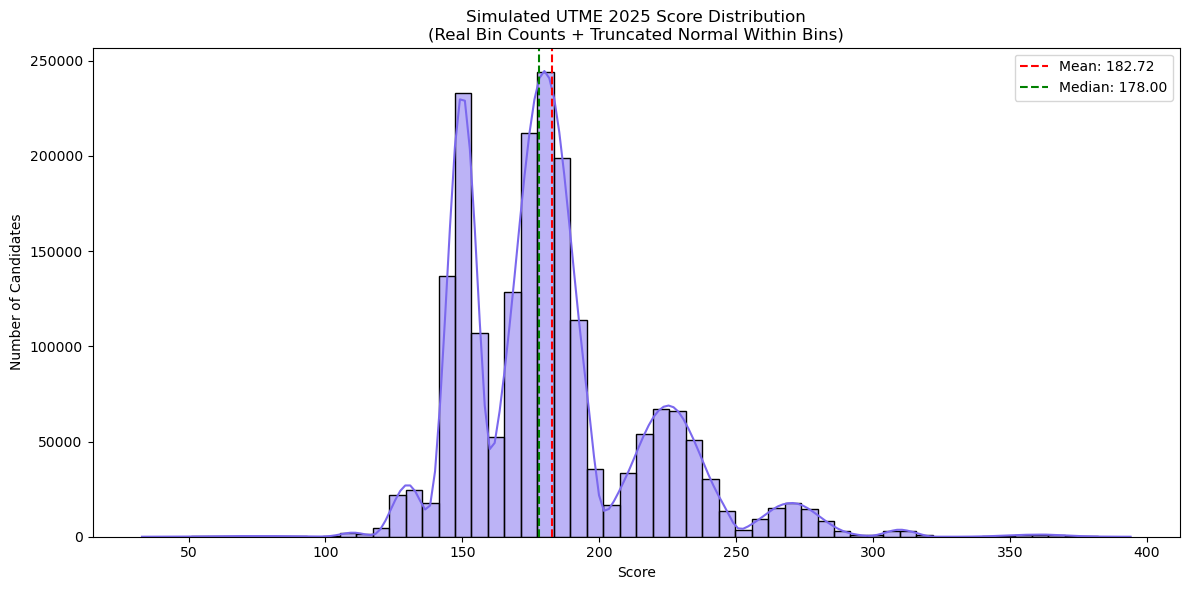

In [18]:
plt.figure(figsize=(12, 6))
sns.histplot(df['UTME_Score'], bins=60, kde=True, color='mediumslateblue', edgecolor='black')
plt.axvline(df['UTME_Score'].mean(), color='red', linestyle='--', label=f"Mean: {df['UTME_Score'].mean():.2f}")
plt.axvline(df['UTME_Score'].median(), color='green', linestyle='--', label=f"Median: {df['UTME_Score'].median():.2f}")
plt.title('Simulated UTME 2025 Score Distribution\n(Real Bin Counts + Truncated Normal Within Bins)')
plt.xlabel('Score')
plt.ylabel('Number of Candidates')
plt.legend()
plt.tight_layout()
plt.savefig('utme_final_distribution.png')
plt.show()

## Score Spread and Outliers

The boxplot below summarizes score dispersion, including the median, interquartile range, and potential outliers. It helps identify performance variability and score concentration.

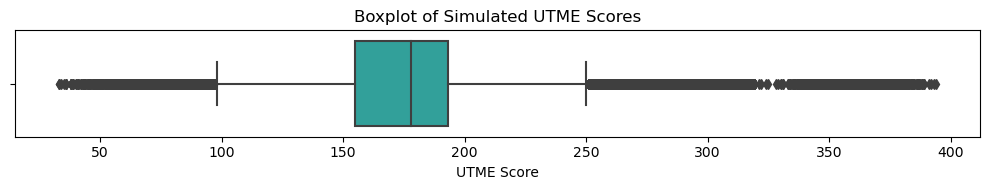

In [20]:
plt.figure(figsize=(10, 2))
sns.boxplot(x=df['UTME_Score'], color='lightseagreen')
plt.title('Boxplot of Simulated UTME Scores')
plt.xlabel('UTME Score')
plt.tight_layout()
plt.savefig('utme_boxplot.png')
plt.show()

## Score Band Breakdown

We group scores into official JAMB intervals and show how candidates are distributed. This helps interpret raw scores in grouped context and compare proportions across ranges.

,Score Band,Candidates,Percentage (%)
Score_Band,,,
0–99,0–99,2031,0.10
100–119,100–119,3820,0.20
120–139,120–139,57419,2.94
140–159,140–159,488197,24.97
160–199,160–199,983187,50.29
200–249,200–249,334560,17.11
250–299,250–299,73441,3.76
300–319,300–319,7658,0.39
320–400,320–400,4756,0.24


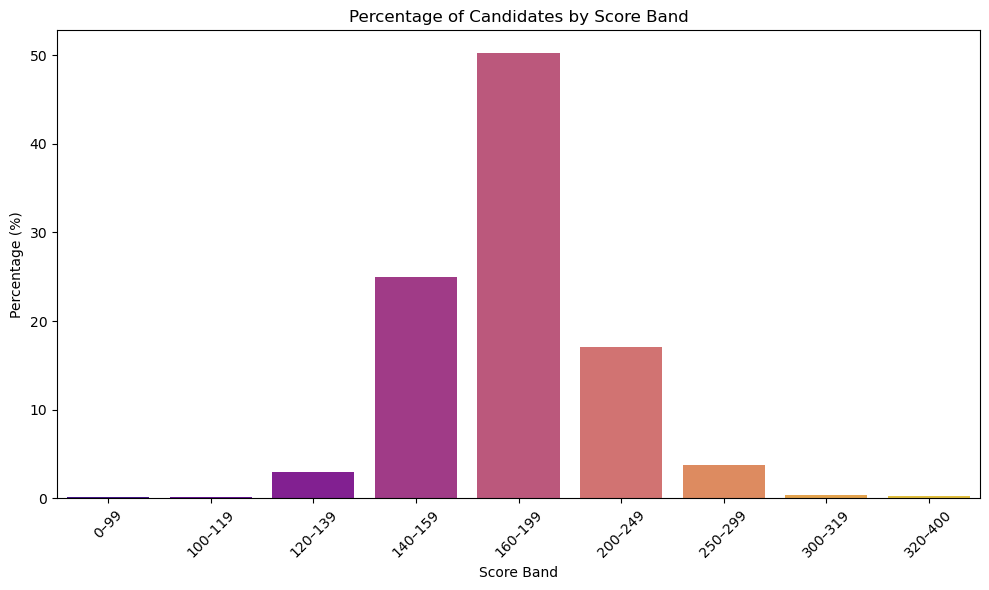

In [22]:
# Re-create score bands
bins = [0, 99, 119, 139, 159, 199, 249, 299, 319, 400]
labels = ['0–99', '100–119', '120–139', '140–159', '160–199', '200–249', '250–299', '300–319', '320–400']
df['Score_Band'] = pd.cut(df['UTME_Score'], bins=bins, labels=labels, right=True)

# Calculate percentages
band_counts = df['Score_Band'].value_counts().sort_index()
band_percentages = (band_counts / len(df)) * 100

band_df = pd.DataFrame({
    'Score Band': labels,
    'Candidates': band_counts.values,
    'Percentage (%)': band_percentages.round(2)
})

# Display table
display(band_df)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Score Band', y='Percentage (%)', data=band_df, palette='plasma')
plt.title('Percentage of Candidates by Score Band')
plt.ylabel('Percentage (%)')
plt.xlabel('Score Band')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('utme_score_bands.png')
plt.show()

## Score Quantiles

Quantiles divide the candidate population into equal segments. This analysis helps determine score thresholds for percentiles such as top 10%, median, or bottom quartile.

In [24]:
quantiles = df['UTME_Score'].quantile(np.arange(0.1, 1.0, 0.1))
quantile_df = quantiles.to_frame(name='Score').reset_index()
quantile_df.columns = ['Quantile', 'Score']
quantile_df['Quantile'] = quantile_df['Quantile'].apply(lambda x: f'{int(x * 100)}th')
display(quantile_df)

,Quantile,Score
0,10th,147.00
1,20th,152.00
2,30th,164.00
3,40th,173.00
4,50th,178.00
5,60th,183.00
6,70th,189.00
7,80th,210.00
8,90th,230.00


## Distribution Shape: Skewness and Kurtosis

Skewness measures symmetry; kurtosis measures the "tailedness" of the distribution. We expect a slightly right-skewed, mesokurtic (normal-like) distribution for exam data.

In [26]:
skewness = df['UTME_Score'].skew()
kurtosis = df['UTME_Score'].kurt()

print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

Skewness: 1.16
Kurtosis: 2.33


## Comparison of Top and Bottom Performers

We compare candidates in the top 10% vs bottom 10% to observe differences in score spread and distribution characteristics.

/Users/wale/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/wale/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


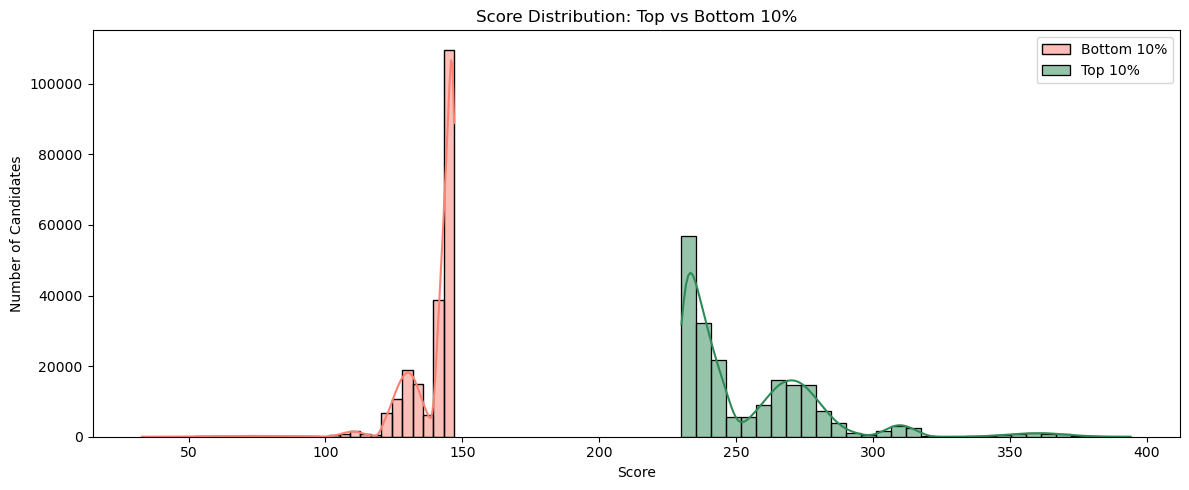

In [28]:
# Compute thresholds
q90 = df['UTME_Score'].quantile(0.9)
q10 = df['UTME_Score'].quantile(0.1)

top_10 = df[df['UTME_Score'] >= q90]
bottom_10 = df[df['UTME_Score'] <= q10]

# Plot
plt.figure(figsize=(12, 5))
sns.histplot(bottom_10['UTME_Score'], color='salmon', label='Bottom 10%', kde=True, bins=30)
sns.histplot(top_10['UTME_Score'], color='seagreen', label='Top 10%', kde=True, bins=30)
plt.title('Score Distribution: Top vs Bottom 10%')
plt.xlabel('Score')
plt.ylabel('Number of Candidates')
plt.legend()
plt.tight_layout()
plt.savefig('utme_top_bottom_10.png')
plt.show()

## Statistical Comparison Between Score Bands

To test whether differences between score bands are statistically significant, we apply:
- **Independent two-sample t-test** to compare means between two bands  
- **ANOVA (Analysis of Variance)** across multiple bands  
- **Levene’s test** for equality of variances  

This helps assess whether banded scores reflect genuinely different performance levels or just random variation.

In [30]:
from scipy.stats import ttest_ind, levene

# Filter groups
group_160_199 = df[(df['UTME_Score'] >= 160) & (df['UTME_Score'] <= 199)]['UTME_Score']
group_200_249 = df[(df['UTME_Score'] >= 200) & (df['UTME_Score'] <= 249)]['UTME_Score']

# T-test
t_stat, p_val = ttest_ind(group_160_199, group_200_249, equal_var=False)
print(f"T-test (160–199 vs 200–249): t = {t_stat:.2f}, p = {p_val:.4f}")

# Levene’s test for variance equality
w_stat, p_levene = levene(group_160_199, group_200_249)
print(f"Levene’s Test: W = {w_stat:.2f}, p = {p_levene:.4f}")

T-test (160–199 vs 200–249): t = -2205.76, p = 0.0000
Levene’s Test: W = 23105.38, p = 0.0000


In [31]:
from scipy.stats import f_oneway

# Select multiple bands
group_140_159 = df[(df['UTME_Score'] >= 140) & (df['UTME_Score'] <= 159)]['UTME_Score']
group_160_199 = df[(df['UTME_Score'] >= 160) & (df['UTME_Score'] <= 199)]['UTME_Score']
group_200_249 = df[(df['UTME_Score'] >= 200) & (df['UTME_Score'] <= 249)]['UTME_Score']
group_250_299 = df[(df['UTME_Score'] >= 250) & (df['UTME_Score'] <= 299)]['UTME_Score']

# ANOVA test
f_stat, p_anova = f_oneway(group_140_159, group_160_199, group_200_249, group_250_299)
print(f"ANOVA (across 140–299): F = {f_stat:.2f}, p = {p_anova:.4f}")

ANOVA (across 140–299): F = 8321051.71, p = 0.0000


In [32]:
from scipy.stats import mannwhitneyu

u_stat, p_mwu = mannwhitneyu(group_160_199, group_200_249, alternative='two-sided')
print(f"Mann–Whitney U Test: U = {u_stat:.2f}, p = {p_mwu:.4f}")

Mann–Whitney U Test: U = 0.00, p = 0.0000
